In [107]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

#gamma function
from scipy import special, optimize


#Fitting the spectrum
from scipy.optimize import curve_fit

#Using csv tables
import pandas as pd

#Astropy module to handle units
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B,m_e,e

The goal of this notebook is to fit the radio emission of the supernova 1993J, data can be extracted from https://iopscience.iop.org/article/10.1086/523258/pdf and is also aviable in this Github. 

# 1. Introduction.

First, we need to save all the spectrum data in python variables.

In [108]:
#Initialice the data ararys where the first value will be the wavelenght name
data=[]

data_1=[]
data_2=[]
data_3=[]
data_6=[]
data_20=[]

#Extract the data
data= pd.read_csv("Data/Datos SuperNova - 1.2_cm.csv")
data_1.extend(('1.2', data))

data= pd.read_csv("Data/Datos SuperNova - 2_cm.csv")
data_2.extend(('2', data))

data= pd.read_csv("Data/Datos SuperNova - 3.6_cm.csv")
data_3.extend(('3.6', data))

data= pd.read_csv("Data/Datos SuperNova - 6_cm.csv")
data_6.extend(('6', data))

data= pd.read_csv("Data/Datos SuperNova - 20_cm.csv")
data_20.extend(('21', data))

data= []
data.extend((data_1, data_2, data_3, data_6, data_20))

#visualice the data, Flux is in mJy
data[0][1]

,Days,Telescope,Flux,Error
0,11.37,VLA B,18.940,1.905
1,12.33,VLA B,22.487,2.261
2,13.04,VLA B,25.753,2.576
3,13.46,VLA B,25.550,2.578
4,14.25,VLA B,28.640,2.875
...,...,...,...,...
77,3213.38,VLA D/A,2.495,0.282
78,3708.93,VLA A,1.928,0.237
79,3959.47,VLA B/C,1.792,0.191
80,4184.57,VLA A,0.967,0.217


Making a plot to visualice the data.

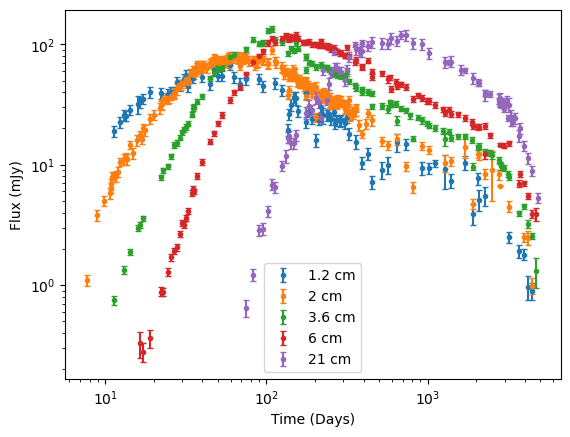

In [109]:
for wavelenght in data:
    plt.errorbar(wavelenght[1].Days, wavelenght[1].Flux, yerr=wavelenght[1].Error, 
                 fmt = '.', capsize=2, label= f'{wavelenght[0]} cm')
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Flux (mJy)")
plt.xlabel("Time (Days)")
plt.legend()

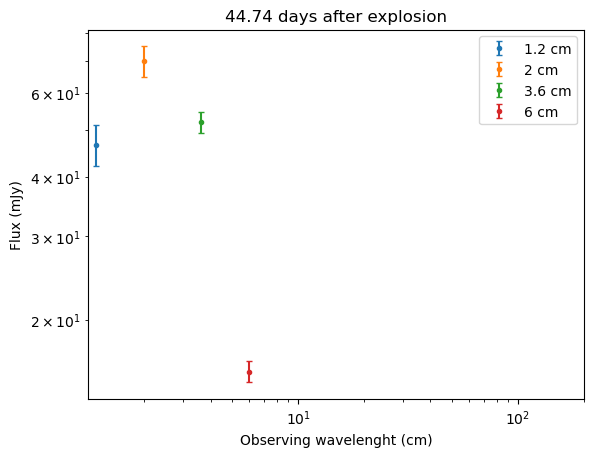

In [110]:
#array with all the days, we will make an array with all the list, remove duplicates and order it
DayArray=[]
DayArray=(list(data_1[1].Days) + list(data_2[1].Days)+ list(data_3[1].Days) + list(data_6[1].Days)
          + list(data_20[1].Days))

DayArray= list(set(DayArray))
DayArray.sort()

CopyArray= DayArray.copy()
#Remove days with less than 1 wavelenght
for i, dayStart in enumerate(DayArray):
    counter=0
    for wavelenght in data:
        for days in wavelenght[1].Days:
            if days == dayStart:
                counter=counter+1
    if counter < 3:
        CopyArray.remove(dayStart)
        
#Select a day for the frequency plot
DayArray=CopyArray.copy()
day= DayArray[20]



for wavelenght in data:
    for i, days in enumerate(wavelenght[1].Days):
        if days==day:
            plt.errorbar(float(wavelenght[0]), wavelenght[1].Flux[i], yerr=wavelenght[1].Error[i], 
                         fmt = '.', capsize=2, label= f'{wavelenght[0]} cm')

plt.xscale("log")
plt.yscale("log")
plt.ylabel("Flux (mJy)")
plt.xlabel("Observing wavelenght (cm)")
plt.xlim(right=200)
plt.title(f'{day} days after explosion')
plt.legend()

# 2. Theoretical preview and data.

In order to make this analysis we will be folowing the paper The role of synchrotron self-absorption in the late radio emission from SN 1993J (https://www.aanda.org/articles/aa/abs/2001/30/aah2783/aah2783.html)   (Pérez-Torres, Alberdi and Marcaide). We assume a modified standard interaction model (SIM), where we have a strong interaction between the supernova and the interacting medium; this interactions leads to a self-similarly expanding shell structure, and in this modified scenario the synchrotron emission comes from the shell formed short after the breakout. This emission is assumed to be due relativistic electron population $N(E,r)$ in a magnetic field $B(r)$, and that the injected electron distribution is driven by a power law
$$
            N(E,r)=N_0(r) E^{-p}
$$
We also have some more information from previus observations and asumptions: (i) distance to SN1993J is $D=3.6~Mpc$; (ii) the supernova exploded in March 28, 1993; (iii) supernova deceleration parameter is $m=0.86$; (iv) the width of the radio emiting shell is $\Delta R = 0.3 R_{shock}$; (v) the index of the circumstellar density is $s=1.66$ and (vi) the same temperature proffile as FB98, i.e., 
$$
        T_e(r) =max\left[ T_{15}(10^{15}cm/r), 2 \cdot 10^{5}~K \right],
$$
where $T_{15}$ is the electron temperature in the circumstellar medium at $r= 10^{15}~cm$; in this case it is $1.7\cdot 10^6~K$. The region change occurs for $r_l= 8.5 \cdot 10^{15}~cm$. 4.33 e 6 a r0 probar con parametro libre esto mirar tambien los dias y el offset en el tiempo y probar tmb con 2.7 a los 10^15. ESTO ESTA MAL, LA TEMPERATURA NO ES UNA A CADA TIEMPO, ES UN PERFIL DE TEMPERATURAS CONSTANTE EN T

In [111]:
def ThermalElectronsTemp(radius):
    """
    Returns the temperature of the thermal electrons in FB98 given a vector of radius in cm

    Parameters
    :radius: Radius in cm at which the temperature will be computed

    Output
    :Temperature: Array of temperature of the thermal electrons at the given radius array
    """
    
    aux= np.array(1.7e6*1e15/radius)
    aux2= 2.5e5*np.ones(aux.shape)
    Temperature=np.zeros(aux.shape)
    for i in np.arange(0, aux.size):
        Temperature[i]= max([aux[i], aux2[i]])
    return Temperature

From their VLBI observations we know that 
$$
            B \propto r^{-1} ~~~~~~~~~~~ N_0 \propto r^{-2}.
$$
The fitting parameters will be: 
    (i)   the spectral index of injected electron population, p
    (ii)  Initial magnetic field $B_0$
    (iii) Initial value of the injected function of electrons
    (iv)  Low energy cut for relativistic electrons $\gamma_{min}(r_0) = E_{min}(r_0)/m_ec^2$
The reference radius is $r_0=6.35 \cdot 10^{14}~cm$, corresponding to the outer shell radius at their first data point $t_0=2.34~days$.

The expansion will be driven by 
$$
        R_{shock} \propto t^{0.86},
$$
meaning that 36.8 days after the explosion the supernova radius will be $r_l$.

In [112]:
def PLradius(time, time0, r0, a=0.86):
    """
    PLradius gives the radius after a given t of an expanding object with initial radius and a given speed driven by a power law

    Parameters
    :time: time of the expansion
    :time0: reference time
    :r0: radius at reference time
    :a: parameter of the power law

    Output
    :r: radius at the end of the expansion
    """
    
    r=r0*(time**a)/(time0**a)
    return r

def Br(r, B0, r0, s, a=0.86):
    """
    Br returns the value of the magnetic field at a given r known the value B0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :B0: magnetic field at a starting radius
    :r0: radius at starting
    :s: Circumstellar medium density index
    :a: parameter of the r expansion power law
    
    Output
    :Br: Magentic field at a radius r of the object
    """
    
    Br=B0*((r/r0)**(1-s/2-1/a))
    return Br

def Nr(r, N0, r0, p, s, a=0.86):
    """
    Nr returns the value of the electron density at a given r known the value N0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :N0: electron density at a starting radius
    :r0: radius at starting
    :p: exponent of the power law
    :s: Circumstellar medium density index

    Output
    :Nr: electron density at a radius r of the object
    """
    
    Nr=N0*(r/r0)**(2*(1-s/2-1/a))
    return Nr

From Pacholcyzk expression (3.53) we have that the synchrotron intensity from a power law population of electrons is given by (https://www.mpi-hd.mpg.de/personalhomes/frieger/HEA6.pdf)
$$
    I_\nu = S(\nu) \int e^{-\tau_\nu}d\tau_\nu,
$$
where $S(\nu_1)= \frac{\epsilon_\nu}{\kappa_\nu}$ is the source function and $d\tau_\nu = \kappa_\nu  ds$. This way the flux is simply
$$
    F_\nu = \Omega I_\nu = \frac{\pi R^2}{D^2}I_\nu.
$$
We want model a system where free-free absoption and syncrothron self absortion are present, emission and absorption coefficient for a synchrotron source are
$$
\begin{aligned}
    \epsilon_\nu &=c_5(\gamma) N_0B^{(\gamma+1) / 2}\left(\frac{\nu}{2 c_1}\right)^{(1-\gamma) / 2}, \\
    \kappa_\nu & =c_6(\gamma) N_0B^{(\gamma+2) / 2}\left(\frac{\nu}{2 c_1}\right)^{-(\gamma+4) / 2},
\end{aligned}
$$
The emission intensity from a free-free is given by   and the absorption coefficient for free-free absorption in a relativistic population of electrons is
$$
        \kappa_{\nu,ff} = 9.8 \cdot 10^{-3} \frac{n_{cs}^2}{T_e^{1.5} \nu^{2}} \left( 17.7 + ln\frac{T^{1.5}}{\nu} \right)\\
$$
We will have 2 regions, the shell, containing the synchrotron process and thus it's emission and absorption; and the exterior, with free-free process. This way the final intensity will be the sum of the intensity of both regions.
$$
            I_\nu = I_{synch}e^{\tau_{ff}} = \frac{\epsilon_\nu}{\kappa_\nu}\cdot \left(1- e^{-R_{shock} \kappa_\nu} \right)e^{\tau_{ff}}
$$
where the optical depth is $d\tau_\nu = \kappa_\nu ds$.

The optical depth for free free absorption can be computed by integrating on the line of sight (LOS LIMTES DE INTEGRACION NO SERIAN HASTA INFINITO CON LO QUE ME DIVERGE EL TAU?)
$$
            \tau_{\nu, ff}= \frac{n_{cs}^2}{\nu^{2.1}}\cdot \left( \frac{1}{T_{ref}r_{ref}} \right)^{1.5} \left[ \frac{2}{5}(r_l^{2.5}-R_s^{2.5}) +  \frac{1}{T_{cte}^{1.5}}R_s\right]
$$

In [139]:
def CalculateLimitR(Tcte, Tref, rRef):
    rl=Tref*rRef/Tcte
    
    return rl

def FreeFreeOpticalDepth(frequency, s, ne, Rs, Tcte=2e5, Tref=4.33e6, rRef=6.35e14):
    rl= CalculateLimitR(Tcte, Tref, rRef)
    tau= ne**2/frequency**(2.1)*(1/(Tref*rRef))**(1.5)*(2/5*(rl**(2.5)-Rs**(2.5))+ Rs/Tcte**(2.5))
    
    return tau

In [114]:
#Defining absorption and emission coefficients
def SynchrotronEmissionCoeff(p, B, N0, frequency):
    """
    Returns the emission coefficient for a synchrotron emisison of a population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the emission coefficient want to be calculated

    Output
    :EmissionCoeff: Emission coefficient value
    """

    EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
    return EmissionCoeff

def SynchrotronAbsorptionCoeff(p, B, N0, frequency):
    """
    Returns the absorption coefficient for a synchrotron population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
    return AbsorptionCoeff


def FreeFreeAbsorptionCoeff(Te, Ne, frequency):
    """
    Returns the absorption coefficient for a free free process in cgs units

    Parameters
    :Te: Temperature of the electrons
    :Ne: Electron number density
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    #AbsorptionCoeff=(9.8e-3*Ne*Ne/(Te**(1.5)*frequency**(2.)))*(17.7+np.log(Te**(1.5)/frequency))
    AbsorptionCoeff=Ne*Ne/(Te**(1.5)*frequency**(2.1))
    return AbsorptionCoeff

The constants $c_i$ (Pacholzyzk)
$$
c_1=\frac{3 e}{4 \pi m^3 c^5},
$$

$$
c_5=\frac{\sqrt{3}}{16 \pi} \frac{e^3}{m c^2}\left(\frac{\gamma+7 / 3}{\gamma+1}\right) \Gamma\left(\frac{3 \gamma-1}{12}\right) \Gamma\left(\frac{3 \gamma+7}{12}\right),
$$

$$
c_6=\frac{\sqrt{3} \pi}{72} e m^5 c^{10}\left(\gamma+\frac{10}{3}\right) \Gamma\left(\frac{3 \gamma+2}{12}\right) \Gamma\left(\frac{3 \gamma+10}{12}\right),
$$

In [115]:
#Defininf Pacholcyzk's constants
c1=(const.e.esu*3/(4*np.pi*const.m_e**3*c**5)).cgs.value

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    c5=3**0.5/(16*np.pi)*(const.e.esu**3/(const.m_e*const.c**2))*(p+7/3)/(p+1)*scipy.special.gamma((3*p-1)/12)*scipy.special.gamma((3*p+7)/12)
    #return only the value in cgs units to make possible a fit
    return c5.cgs.value
    
def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    c6=np.pi*3**0.5/(72)*const.e.esu*const.m_e**5*const.c**10*(p+10/3)*scipy.special.gamma((3*p+2)/12)*scipy.special.gamma((3*p+10)/12)
    return c6.cgs.value

The thermal electron density for free-free process is characterized by
$$
            n_{cs}=1.27 \cdot 10^8 M_W(r/6.35\cdot 10^{14} cm)^{-s} cm^{-3},
$$
where, for this case $s=1.66$ and $M_W$ is the wind parameter
$$
            M_W = \frac{\dot{M}}{10^{-5} M_\odot~yr^{-1}} (v_w/10 km/s)^{-1},
$$
where $\dot{M}$ and $v_w$ are the mass loss rate and velocity of the presupernova wind. These come from the observations, and are obtained by Fransson, Lundqvist and Chevalier in (https://ui.adsabs.harvard.edu/abs/1996ApJ...461..993F/abstract), with a value of
$$
        \dot{M} \approx 5 \cdot 10^{-5}~\frac{M_{\odot}}{yr}~~~~~~~v_w= 10~ \frac{km}{s},
$$
so the value for the thermal electron density is
$$
                n_{cs}= 5.08\cdot 10^{8}\left(\frac{r}{6.35\cdot 10^{14} cm}\right)^{-1.66} cm^{-3},
$$

In [116]:
def ThermalElectronDensity(radius, s):
    """
    Returns thermal electron density for a given expansion radius in cm for 1993J

    Parameters
    :radius: Radius at which the density will be computed

    Output
    :n: thermal electron density in cgs
    """

    n= 6.35e8*(radius/6.35e14)**(-s)
    return n

def SourceFuncSynch(p, B, N0, frequency):
    """
    returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :N0: Constant of the power law
    :Ne: Thermal electron number density
    :Te: Temperature of the electrons
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """

    S=SynchrotronEmissionCoeff(p, B, N0, frequency)/(SynchrotronAbsorptionCoeff(p, B, N0, frequency))
    return S

We can now compute the intensity and the flux.

In [132]:
def SpecIntFull(p, B, N, radius, time, shellRadius, frequency, s, I0=0):
    """
    SpecIntSynch returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :p: exponent of the power law
    :B: Magnetic field
    :N: Constant of the power law
    :Te: Temperature of the electrons
    :radius: Starting radius of the shell
    :shellRadius: diference between bigger and smaller radius of the emitting shell
    :I0: Outgoing intensitty of the shell if there was no synchrotron emission
    :frequency: frequency at which the specific intensity is computed

    Output
    :I: specific intensity at the given frequency
    """

    S =SourceFuncSynch(p, B, N, frequency)
    kappa= SynchrotronAbsorptionCoeff(p, B, N, frequency)
    Te=ThermalElectronsTemp(radius)
    Ne=ThermalElectronDensity(radius, s)
    kappa_ff=FreeFreeAbsorptionCoeff(Te, Ne,frequency)
    #absorption_ff= np.exp(-radius*kappa_ff)
    absorption_ff= np.exp(-FreeFreeOpticalDepth(frequency, s, Ne, radius))
    
    I=I0*absorption_ff + S*(1 - np.exp(-shellRadius*kappa))*absorption_ff
    return I

def SpecIntSynch(p, B, N, radius, time, shellRadius, frequency, s, I0=0):
    """
    SpecIntSynch returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :p: exponent of the power law
    :B: Magnetic field
    :N: Constant of the power law
    :Te: Temperature of the electrons
    :radius: Starting radius of the shell
    :shellRadius: diference between bigger and smaller radius of the emitting shell
    :I0: Outgoing intensitty of the shell if there was no synchrotron emission
    :frequency: frequency at which the specific intensity is computed

    Output
    :I: specific intensity at the given frequency
    """

    S =SourceFuncSynch(p, B, N, frequency)
    kappa= SynchrotronAbsorptionCoeff(p, B, N, frequency)
    Te=ThermalElectronsTemp(radius)
    Ne=ThermalElectronDensity(radius, s)
    kappa_ff=FreeFreeAbsorptionCoeff(Te, Ne,frequency)
    absorption_ff= np.exp(-radius*kappa_ff)
    
    I=I0*absorption_ff + S*(1 - np.exp(-shellRadius*kappa))
    return I

def SpecIntFF(p, B, N, radius, time, shellRadius, frequency, s, I0=0):
    """
    SpecIntSynch returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :p: exponent of the power law
    :B: Magnetic field
    :N: Constant of the power law
    :Te: Temperature of the electrons
    :radius: Starting radius of the shell
    :shellRadius: diference between bigger and smaller radius of the emitting shell
    :I0: Outgoing intensitty of the shell if there was no synchrotron emission
    :frequency: frequency at which the specific intensity is computed

    Output
    :I: specific intensity at the given frequency
    """

    S =SourceFuncSynch(p, B, N, frequency)
    kappa= SynchrotronAbsorptionCoeff(p, B, N, frequency)
    Te=ThermalElectronsTemp(radius)
    Ne=ThermalElectronDensity(radius, s)
    kappa_ff=FreeFreeAbsorptionCoeff(Te, Ne,frequency)
    #absorption_ff= np.exp(-radius*kappa_ff)
    absorption_ff= np.exp(-FreeFreeOpticalDepth(frequency, s, Ne, radius))
    
    I=I0*absorption_ff + S*absorption_ff
    return I

def solidangle(radius, distance):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :radius: radius of the source
    :distance: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (radius**2)/(distance**2)
    return omega

In [133]:
def FluxatTFull(time, time0, frequency, p, B0, N0, distance, r0, s, a=0.86, I0=0, offset=0):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :time: Time at wich the flux is calculated
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B0: Magnetic field when radius is r0
    :N0: Constant of the power law
    :I0: Outgoing intensitty of the shell if there was no synchrotron emission
    :distance: Distance to the source
    :r0: reference radius of the source
    :speed: speed of the expansion
    :a: exponent of the power law describing expansion
    :offset: Optional parameter to make a fit with the offset of the time
    
    Output
    :F: Flux of the source
    """
    #Computing the radius at a given time
    r=PLradius(time, time0, r0, a)
    #Computing number density and magentic field for the corresponding r
    B= Br(r, B0, r0, s)
    N= Nr(r, N0, r0, p, s)
    
    F=solidangle(r, distance)*SpecIntFull(p, B, N, r, time, 0.3*r, frequency, s, I0)
    return F*1e23 #In order to get from cgs to Jy

def FluxatTSynch(time, time0, frequency, p, B0, N0, distance, r0, s, a=0.86, I0=0, offset=0):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :time: Time at wich the flux is calculated
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B0: Magnetic field when radius is r0
    :N0: Constant of the power law
    :I0: Outgoing intensitty of the shell if there was no synchrotron emission
    :distance: Distance to the source
    :r0: reference radius of the source
    :speed: speed of the expansion
    :a: exponent of the power law describing expansion
    :offset: Optional parameter to make a fit with the offset of the time
    
    Output
    :F: Flux of the source
    """
    #Computing the radius at a given time
    r=PLradius(time, time0, r0, a)
    #Computing number density and magentic field for the corresponding r
    B= Br(r, B0, r0, s)
    N= Nr(r, N0, r0, p, s)
    
    F=solidangle(r, distance)*SpecIntSynch(p, B, N, r, time, 0.3*r, frequency, s, I0)
    return F*1e23 #In order to get from cgs to Jy

def FluxatTFF(time, time0, frequency, p, B0, N0, distance, r0, s, a=0.86, I0=0, offset=0):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :time: Time at wich the flux is calculated
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B0: Magnetic field when radius is r0
    :N0: Constant of the power law
    :I0: Outgoing intensitty of the shell if there was no synchrotron emission
    :distance: Distance to the source
    :r0: reference radius of the source
    :s: external absorbing medium absorbing constant 
    :Emin: Low energy cut off for relativistic electrons 
    :a: exponent of the power law describing expansion
    :offset: Optional parameter to make a fit with the offset of the time
    
    Output
    :F: Flux of the source
    """
    #Computing the radius at a given time
    r=PLradius(time, time0, r0, a)
    #Computing number density and magentic field for the corresponding r
    B= Br(r, B0, r0, s)
    N= Nr(r, N0, r0, p, s)
    
    F=solidangle(r, distance)*SpecIntFF(p, B, N, r, time, 0.3*r, frequency, s, I0)
    return F*1e23 #In order to get from cgs to Jy

We defined our function with frequencies, but sometimes data is given in wavelenght or viceversa, here we make some functions to change between them.

In [134]:
def freqtowavelenght(frequency):
    """
    Transforms from frequency to wavelenght

    Parameters
    :frequency: Input frequency

    Output
    :wavelenght:
    """
    frequency=frequency.to(u.Hz)
    return (const.c/frequency).decompose()

def wavelenghttofreq(wavelenght):
    """
    Transforms from wavelenght to frequency

    Parameters
    :wavelenght: Input wavelenght

    Output
    :frequency:
    """
    wavelenght=wavelenght.to(u.m)
    return (const.c/wavelenght).decompose()

# 3. Plots and fit.

First, let's try to plot the synchrotron zone and check for magnitude orders of the parameters

/home/adri/miniconda3/envs/JAEICU/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


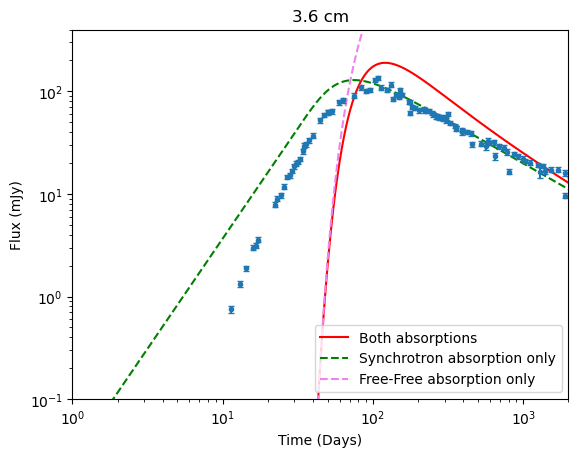

In [140]:
#Checking with the values given by Miguel et al
p=3.
B0=1.7*(27*u.G).value
N0= (6.7e-7*u.erg**(p-1)/u.cm**3).value 
s=1.66

d=(3.6*1e6*u.pc).to(u.cm).value  #Known distance to the binary
r0= (6.35e14*u.cm).value 
time0=(2.34*u.day).value 


I0=0

#Select data
i=2
t=np.linspace(1, 4000, 1000000)

frequency= wavelenghttofreq(float(data[i][0])*u.cm).cgs.value
#I did not get anything with this cutoff
Emin0= (90*const.m_e.cgs*const.c.cgs**2).value

x= data[i][1].Days
y=data[i][1].Flux
err= data[i][1].Error

F1= 1e3*FluxatTFull(t, time0, frequency, p, B0, N0, d, r0, s) #The data is in mJy
F2= 1e3*FluxatTSynch(t, time0, frequency, p, B0, N0, d, r0, s) #The data is in mJy
F3= 1e3*FluxatTFF(t, time0, frequency, p, B0, N0, d, r0, s) #The data is in mJy

plt.plot(t,F1, c='red', label= 'Both absorptions')
plt.plot(t,F2, c='green', linestyle='dashed', label= 'Synchrotron absorption only') 
plt.plot(t,F3, c='violet', linestyle='dashed', label= 'Free-Free absorption only') 
plt.errorbar(x,y, yerr= err,fmt = '.', capsize=2) 


plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1,400)
plt.xlim(1,2000)
plt.ylabel("Flux (mJy)")
plt.xlabel("Time (Days)")
plt.title(f'{data[i][0]} cm')
plt.legend()
plt.show()


We can make the same but for frequency plot for a given time.

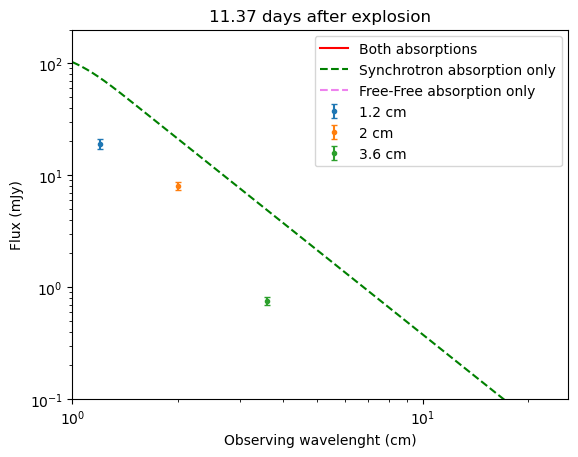

In [141]:
day= DayArray[0]
WavelenghtArray= [1.2*u.cm, 2*u.cm, 3.6*u.cm, 6*u.cm, 20*u.cm]
WavelenghtContinum= np.linspace(0.1*u.cm, max(WavelenghtArray), 10000)


F1= 1e3*FluxatTFull(np.array([day]), time0, wavelenghttofreq(WavelenghtContinum).value, p, B0, N0, d, r0, s)
F2= 1e3*FluxatTSynch(np.array([day]), time0, wavelenghttofreq(WavelenghtContinum).value, p, B0, N0, d, r0, s)
F3= 1e3*FluxatTFF(np.array([day]), time0, wavelenghttofreq(WavelenghtContinum).value, p, B0, N0, d, r0, s)


plt.plot(WavelenghtContinum,F1, c='red', label= 'Both absorptions')
plt.plot(WavelenghtContinum,F2, c='green', linestyle='dashed', label= 'Synchrotron absorption only') 
plt.plot(WavelenghtContinum,F3, c='violet', linestyle='dashed', label= 'Free-Free absorption only') 
for wavelenght in data:
    for i, days in enumerate(wavelenght[1].Days):
        if days==day:
            plt.errorbar((float(wavelenght[0])),
                         wavelenght[1].Flux[i], yerr=wavelenght[1].Error[i], 
                         fmt = '.', capsize=2, label= f'{wavelenght[0]} cm')

plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1,200)
plt.xlim(1)
plt.ylabel("Flux (mJy)")
plt.xlabel("Observing wavelenght (cm)")
plt.title(f'{day} days after explosion')
plt.legend()

We can now procceed to fit the data, for this we will fit all the wavelenghts simultaneously.

In [122]:
def leastsq_function(params, *args):
    #Params and args, if different are wanted to be fitted or to be fitted separately move from args to params or vice-versa
    
    B0 = params[0]
    N0= params[1]
    
    time = args[0]
    FluxValue = args[1]
    frequency = args[2]
    distance = args[3]
    r0 = args[4]
    time0= args[5]
    p = args[6]
    s = args[7]
    
    #Starting the vectors
    Fluxfit = []
    for Flux, freq in zip(FluxValue, frequency):
        Fluxfitaux= 1e3*FluxatTFull(time[i], time0, freq, p, B0, N0, distance, r0, s)
        Fluxfit.append(abs(Fluxfitaux-Flux))

    
    return sum(Fluxfit)

In [123]:
time=[]
FluxDens=[]
frequency=[]
for i in np.arange(0, len(data)):
    time.append(data[1][1].Days)
    FluxDens.append(data[1][1].Flux)
    frequency.append(float(wavelenghttofreq(data_2[0]*u.cm).cgs.value))

frequencies=np.array(frequency)
params0 = (B0, N0)
args = (time, FluxDens, frequencies, d, r0, time0, p, s)
result = scipy.optimize.leastsq(leastsq_function, params0, args=args)

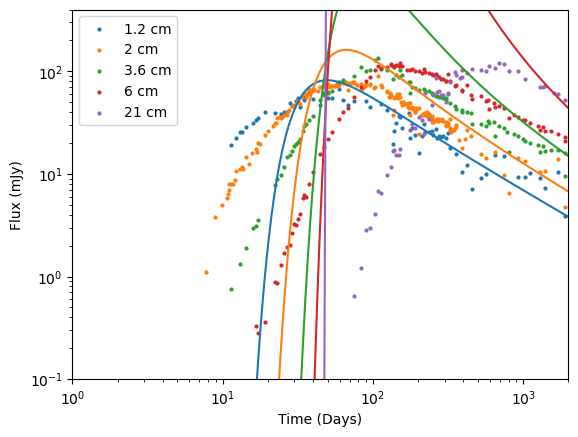

In [124]:
for i in np.arange(0,len(data)):
    x= data[i][1].Days
    y=data[i][1].Flux
    
    F1= 1e3*FluxatTFull(t, time0, wavelenghttofreq(float(data[i][0])*u.cm).cgs.value,
                    p, B0, N0, d, r0, s) #The data is in mJy
    plt.plot(t,F1) 
    plt.scatter(x,y, label=f'{data[i][0]} cm', s= 4) 


plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1,400)
plt.xlim(1,2000)
plt.ylabel("Flux (mJy)")
plt.xlabel("Time (Days)")
plt.legend()
plt.show()

In [125]:
result[0]

array([8.92112035e+01, 2.51223948e-06])

Im getting flux signicantly lower than expected on the free free absorption zone of the spectrum, this must be related to my calculation (or expression) of the absorption coefficient, I think it may be my Temperature expression or the Mw and vw I used.